In [12]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.lstmattn import LSTMAttentionModel
from src.training_utils import *

# Load segmented data

In [9]:
# load data splits
data_dir = '../Old_Young_Walking_Data/'
train_data = np.load(data_dir + 'Silder_mixed_train_data.npz')
val_data = np.load(data_dir + 'Silder_mixed_val_data.npz')
test_data = np.load(data_dir + 'Silder_mixed_test_data.npz')
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

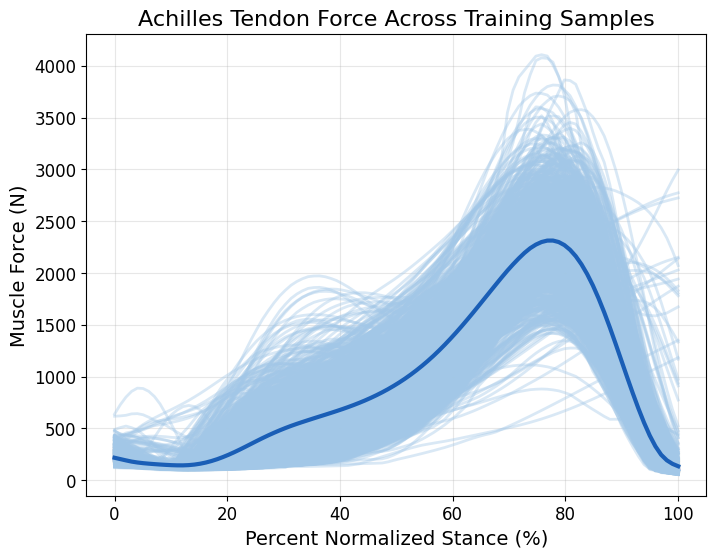

In [10]:
# plot data to double check
plot_achilles_force(y_train)

# Initialize Model

In [13]:
# model parameters
input_size = 3           # grf features (x, y, z)
hidden_size = 64         # hidden size for LSTM (tunable)
num_layers = 2           # number of LSTM layers
num_heads = 4            # number of heads for multi-head attention
output_size = 9          # muscle force features
dropout = 0.1            # dropout rate

model = LSTMAttentionModel(input_size, hidden_size, num_layers, num_heads, output_size, dropout)

In [14]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [18]:
# move the model to the device
model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

# Initialize Hyperparameters and data loaders

In [19]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Train Model

In [20]:
best_model, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 173705.0406, Val Loss: 119679.0817
Epoch [10/1000], Train Loss: 37760.3592, Val Loss: 31690.0786
Epoch [20/1000], Train Loss: 9114.6630, Val Loss: 15491.6276
Epoch [30/1000], Train Loss: 7657.2048, Val Loss: 10487.6658
Epoch [40/1000], Train Loss: 7319.9411, Val Loss: 10667.2662
Early stopping at epoch 41


# Test Model

In [21]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 7573.4404


# Plot Sample Prediction

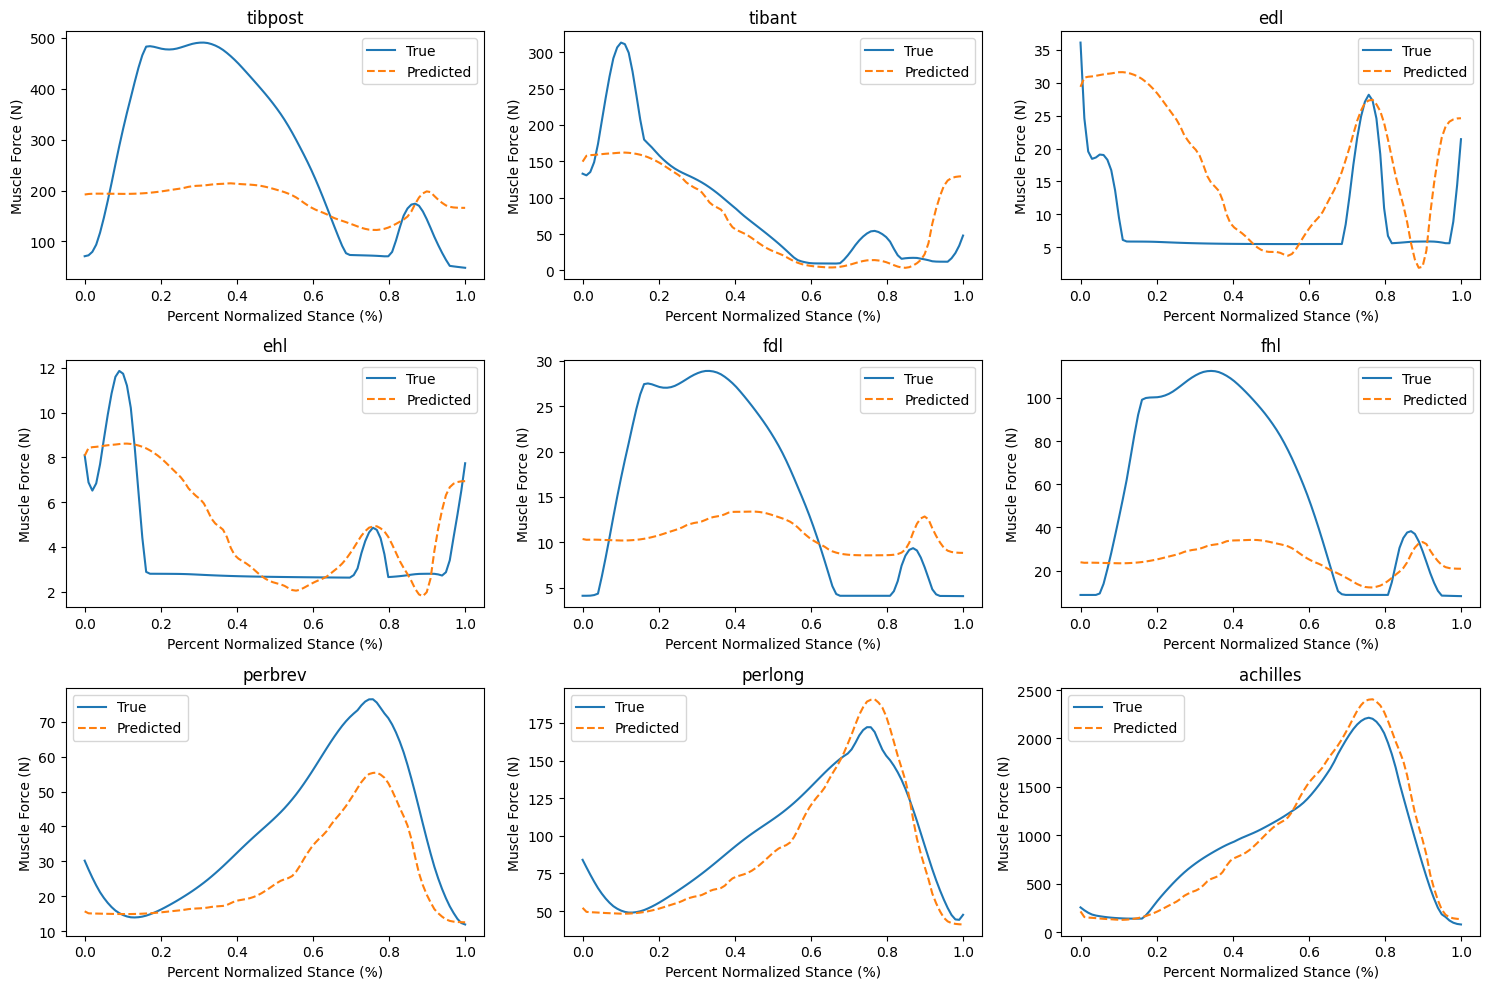

In [22]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)